In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from itertools import product

## Getting Started

In [ ]:
import io
from google.colab import files

# NOTE: upload csv file from local
uploaded = files.upload()
ntfx = pd.read_csv(io.BytesIO(uploaded['RESULTS_ABCDtest_2023-01-19.csv']))
ntfx.head()

Saving RESULTS_ABCDtest_2023-01-19.csv to RESULTS_ABCDtest_2023-01-19.csv


,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,30,75,0.2,TT,15.197544
1,45,75,0.2,TT,11.023851
2,60,75,0.2,TT,11.167915
3,30,85,0.2,TT,14.137107
4,45,85,0.2,TT,13.647546


## Visualization

In the context of given task, 

- metric of interest is the average browse time of all netflix visitors, 
- response variable is the browse time of each single Netflix visitor, 
- one experimental unit is each Netflix visitor. 

In [ ]:
def plot_main_effects(ax, data, df):
    agg = data.groupby(df)['Browse.Time'].mean()
    ax.plot(agg, marker='o')
    ax.set_ylim(13, 20)
    ax.set_xlabel(df)
    ax.set_ylabel('average browse time (min)')


def plot_interaction_effects(ax, data, df1, df2):
    for level in data[df2].unique():
        agg_by_df1 = data[data[df2] == level].groupby(df1)['Browse.Time'].mean()
        ax.plot(agg_by_df1, linestyle='dashed', alpha=0.5, marker='o', label=level)
    
    ax.set_ylim(12, 21)
    ax.set_xlabel(f'DF1: {df1}')
    ax.set_ylabel('RBF')
    ax.legend(loc='upper left', title=f'DF2: {df2}')

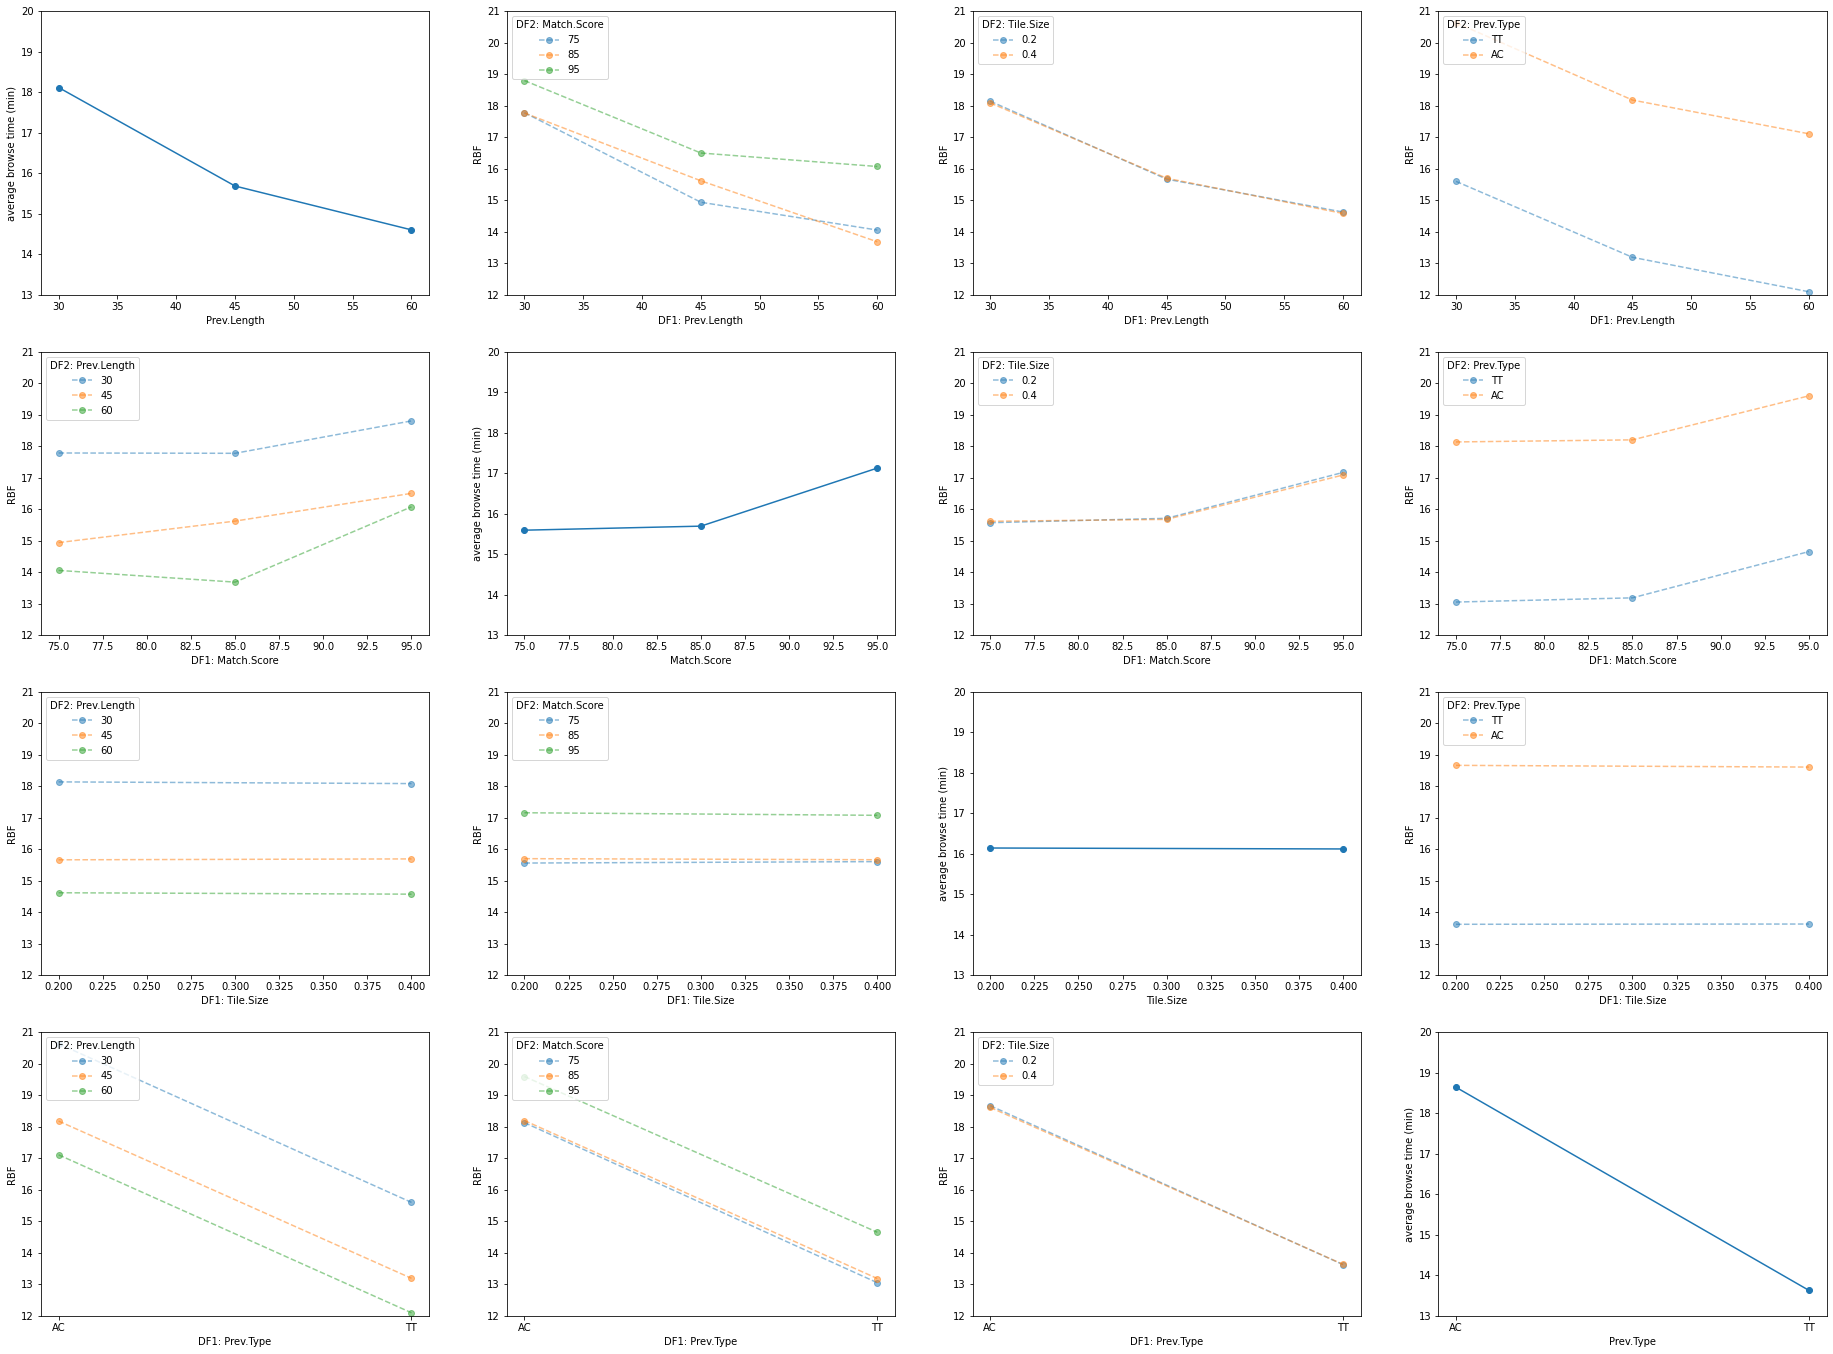

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 24))
dfs = ntfx.columns[:-1]

for i in range(4):
    for j in range(4):
        ax = axes[i][j]
        if i == j:
            plot_main_effects(ax, ntfx, dfs[i])
        else:
            plot_interaction_effects(ax, ntfx, dfs[i], dfs[j])

plt.show()

From above main effect and two-way interaction plots, we find: 

- significant main effect factor: `Prev.Length`, `Match.Score`, `Prev.Type`
- significant two-way interaction: `Prev.Length`-`Match.Score`

These serve as reference for further hypothesis testing. 

## Setting up the Full Model

In [ ]:
ntfx.rename(columns={'Prev.Length': 'PL', 'Match.Score': 'MS', 'Tile.Size': 'TS', 'Prev.Type': 'PT', 'Browse.Time': 'time'}, inplace=True)

The full model:      
$y = \beta_0 + \\
\beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \text{... <-- main effects}\\
\beta_7 x_1 x_3 + \beta_8 x_1 x_4 + \beta_9 x_2 x_3 + \beta_{10} x_2 x_4 + \text{... <-- PL-MS interaction}\\
\beta_{11} x_1 x_5 + \beta_{12} x_2 x_5 + \text{... <-- PL-TS interaction}\\
\beta_{13} x_1 x_6 + \beta_{14} x_2 x_6 + \text{... <-- PL-PT interaction}\\
\beta_{15} x_3 x_5 + \beta_{16} x_4 x_5 + \text{... <-- MS-TS interaction}\\
\beta_{17} x_3 x_6 + \beta_{18} x_4 x_6 + \text{... <-- MS-PT interaction}\\
\beta_{19} x_5 x_6 + \text{... <-- TS-PT interaction}\\
\beta_{20} x_1 x_3 x_5 + \beta_{21} x_1 x_4 x_5 + \beta_{22} x_2 x_3 x_5 + \beta_{23} x_2 x_4 x_5  + \text{... <-- PL-MS-TS interaction}\\
\beta_{24} x_1 x_3 x_6 + \beta_{25} x_1 x_4 x_4 + \beta_{26} x_2 x_3 x_6 + \beta_{27} x_2 x_4 x_6 + \text{... <-- PL-MS-PT interaction}\\
\beta_{28} x_1 x_5 x_6 + \beta_{29} x_2 x_5 x_6 + \text{... <-- PL-TS-PT interaction}\\
\beta_{30} x_3 x_5 x_6 + \beta_{31} x_4 x_5 x_6 + \text{... <-- MS-TS-PT interaction}\\
\beta_{32} x_1 x_3 x_5 x_6 + \beta_{33} x_1 x_4 x_5 x_6 + \beta_{34} x_2 x_3 x_5 x_6 + \beta_{35} x_2 x_4 x_5 x_6 + \text{... <-- PL-MS-TS-PT interaction}
$

where the indicator variables are: 

- $x_1$=1 if Preview.Length=45,    
- $x_2$=1 if Preview.Length=60,    
- $x_3$=1 if Match.Score=85,    
- $x_4$=1 if Match.Score=95,    
- $x_5$=1 if Tile.Size=0.4,    
- $x_6$=1 if Prev.Type=TT.

In [ ]:
full_model = smf.ols('time ~ C(PL) * C(MS) * C(TS) * C(PT)', data=ntfx).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     981.6
Date:                Fri, 20 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:09:35   Log-Likelihood:                -4990.3
No. Observations:                3600   AIC:                         1.005e+04
Df Residuals:                    3564   BIC:                         1.028e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           20.3132      0.097    208.843      0.000      20.122      20.504
C(PL)[T.45]                                         -2.9400      0.138    -21.374      0.000      -3.210      -2.670
C(PL)[T.60]                                         -3.7043      0.138    -26.930      0.000      -3.974      -3.435
C(MS)[T.85]                                          0.0063      0.138      0.046      0.963      -0.263       0.276
C(MS)[T.95]                                          1.0961      0.138      7.969      0.000       0.826       1.366
C(TS)[T.0.4]                                        -0.0123      0.138     -0.089      0.929      -0.282       0.257
C(PT)[T.TT]                                         -5.1127      0.138    -37.169      0.000      -5.382      -4.843
C(PL)[T.45]:C(MS)[T.85]                              0.8024      0.195      4.125      0.000       0.421       1.184
C(PL)[T.60]:C(MS)[T.85]                             -0.3999      0.195     -2.056      0.040      -0.781      -0.018
C(PL)[T.45]:C(MS)[T.95]                              0.6011      0.195      3.090      0.002       0.220       0.983
C(PL)[T.60]:C(MS)[T.95]                              0.8097      0.195      4.162      0.000       0.428       1.191
C(PL)[T.45]:C(TS)[T.0.4]                             0.2320      0.195      1.193      0.233      -0.149       0.613
C(PL)[T.60]:C(TS)[T.0.4]                            -0.0046      0.195     -0.024      0.981      -0.386       0.377
C(MS)[T.85]:C(TS)[T.0.4]                            -0.0799      0.195     -0.411      0.681      -0.461       0.301
C(MS)[T.95]:C(TS)[T.0.4]                            -0.1713      0.195     -0.881      0.378      -0.553       0.210
C(PL)[T.45]:C(PT)[T.TT]                              0.1424      0.195      0.732      0.464      -0.239       0.524
C(PL)[T.60]:C(PT)[T.TT]                              0.0083      0.195      0.043      0.966      -0.373       0.390
C(MS)[T.85]:C(PT)[T.TT]                             -0.0141      0.195     -0.073      0.942      -0.396       0.367
C(MS)[T.95]:C(PT)[T.TT]                              0.1243      0.195      0.639      0.523      -0.257       0.506
C(TS)[T.0.4]:C(PT)[T.TT]                             0.1162      0.195      0.597      0.550      -0.265       0.498
C(PL)[T.45]:C(MS)[T.85]:C(TS)[T.0.4]                -0.2160      0.275     -0.785      0.432      -0.755       0.323
C(PL)[T.60]:C(MS)[T.85]:C(TS)[T.0.4]                 0.0092      0.275      0.033      0.973      -0.530       0.549
C(PL)[T.45]:C(MS)[T.95]:C(TS)[T.0.4]                -0.3681      0.275     -1.338      0.181      -0.907       0.171
C(PL)[T.60]:C(MS)[T.95]:C(TS)[T.0.4]     

## Experiments

Comparing to the above full model, we first perform a hypothesis test on the significance of the four-way PL-MS-TS-PT interaction using partial ANOVA test. 

$H_o: \beta_{32} = \beta_{33} = \beta_{34} = \beta_{35} = 0 $ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{32, 33, 34, 35\}$. 

In [ ]:
without_1234 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
                + C(PL):C(MS) + C(PL):C(TS) + C(PL):C(PT) + C(MS):C(TS) + C(MS):C(PT) + C(TS):C(PT) \
                + C(PL):C(MS):C(TS) + C(PL):C(MS):C(PT) + C(PL):C(TS):C(PT) + C(MS):C(TS):C(PT)'

without_1234_model = smf.ols(without_1234, data=ntfx).fit()
sm.stats.anova_lm(without_1234_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3568.0,3380.134832,0.0,NaN,NaN,NaN
1,3564.0,3371.750235,4.0,8.384597,2.215667,0.06485


Test statistic t = 2.2157 where $T \sim F_{(4, 3565)}$, and thus p-value = 0.0648 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that the four-way PL-MS-TS-PT interaction is not statistically significant to the average browse time, and thus the corresponding terms should be removed from the full model. 

In [ ]:
# update the full model
full_model = without_1234_model

Then we focus on three-way interactions. We first perform a hypothesis test on the significance of all three-way interaction terms combined to see whether they combined are statistically significant or not. 

$ H_o: \beta_{20} = \beta_{21} = ... = \beta_{31} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{20, 21, ..., 31\}$. 

In [ ]:
without_3FI = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(TS) + C(PL):C(PT) \
               + C(MS):C(TS) + C(MS):C(PT) + C(TS):C(PT)'

without_3FI_model = smf.ols(without_3FI, data=ntfx).fit()
sm.stats.anova_lm(without_3FI_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3580.0,3393.590424,0.0,NaN,NaN,NaN
1,3568.0,3380.134832,12.0,13.455592,1.18362,0.288424


Test statistic t = 1.1836 where $T \sim F_{(12, 3569)}$, and thus p-value = 0.2884 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that all the three-way interaction terms combined is not statistically significant to the average browse time, and thus all the corresponding terms should be removed from the full model. 

In [ ]:
# update the full model
full_model = without_3FI_model

Then we focus on two-way interactions. Similarly We start with performing a hypothesis test on the significance of all two-way interaction terms combined to see whether they combined are statistically significant or not. 

$ H_o: \beta_7 = \beta_8 = ... = \beta_{19} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{7, 8, ..., 19\}$. 

In [ ]:
without_2FI = 'time ~ C(PL) + C(MS) + C(TS) + C(PT)'
without_2FI_model = smf.ols(without_2FI, data=ntfx).fit()
sm.stats.anova_lm(without_2FI_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3593.0,3729.012221,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,13.0,335.421797,27.21896,2.653844e-64


Test statistic t = 27.2190 where $T \sim F_{(13, 3581)}$, and thus p-value = 2.6538e-64 < $\alpha$ = 0.01. We then reject the null hypothesis and conclude that at least one of the two-way interaction terms is statistically significant to the average browse time. This follows by further investigation on which of the six two-way interactions are significant to the average browse time. 

We first test on TS-PT interaction: 

$H_o: \beta_{19} = 0$ vs $H_A: \beta_{19} \neq 0$. 

In [ ]:
without_34 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(TS) + C(PL):C(PT) \
               + C(MS):C(TS) + C(MS):C(PT)'

without_34_model = smf.ols(without_34, data=ntfx).fit()
sm.stats.anova_lm(without_34_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3581.0,3394.476520,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,1.0,0.886096,0.93477,0.333692


Test statistic t = 0.9347 where $T \sim F_{(1, 3581)}$, and thus p-value = 0.3337 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that TS-PT interaction is not statistically significant to the average browse time, and thus should be removed from consideration in the final model. 

We then test on MS-PT interaction: 

$H_o: \beta_{17} = \beta_{18} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{17, 18\}$. 

In [ ]:
without_24 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(TS) + C(PL):C(PT) \
               + C(MS):C(TS) + C(TS):C(PT)'

without_24_model = smf.ols(without_24, data=ntfx).fit()
sm.stats.anova_lm(without_24_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3582.0,3396.458373,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,2.0,2.867949,1.512743,0.220446


Test statistic t = 1.5127 where $T \sim F_{(2, 3581)}$, and thus p-value = 0.2204 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that MS-PT interaction is not statistically significant to the average browse time, and thus should be removed from consideration in the final model. 

We then test on MS-TS interaction: 

$H_o: \beta_{15} = \beta_{16} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{15, 16\}$. 

In [ ]:
without_23 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(TS) + C(PL):C(PT) \
               + C(MS):C(PT) + C(TS):C(PT)'

without_23_model = smf.ols(without_23, data=ntfx).fit()
sm.stats.anova_lm(without_23_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3582.0,3396.048948,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,2.0,2.458524,1.296785,0.273538


Test statistic t = 1.2968 where $T \sim F_{(2, 3581)}$, and thus p-value = 0.2735 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that MS-TS interaction is not statistically significant to the average browse time, and thus should be removed from consideration in the final model. 

We then test on PL-PT interaction: 

$H_o: \beta_{13} = \beta_{14} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{13, 14\}$. 

In [ ]:
without_14 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(TS) \
               + C(MS):C(TS) + C(MS):C(PT) + C(TS):C(PT)'

without_14_model = smf.ols(without_14, data=ntfx).fit()
sm.stats.anova_lm(without_14_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3582.0,3393.881462,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,2.0,0.291038,0.153512,0.857696


Test statistic t = 0.1535 where $T \sim F_{(2, 3581)}$, and thus p-value = 0.8577 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that PL-PT interaction is not statistically significant to the average browse time, and thus should be removed from consideration in the final model. 

We then test on PL-TS interaction: 

$H_o: \beta_{11} = \beta_{12} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{11, 12\}$. 

In [ ]:
without_13 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(MS) + C(PL):C(PT) \
               + C(MS):C(TS) + C(MS):C(PT) + C(TS):C(PT)'

without_13_model = smf.ols(without_13, data=ntfx).fit()
sm.stats.anova_lm(without_13_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3582.0,3394.840005,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,2.0,1.249581,0.65911,0.517374


Test statistic t = 0.6591 where $T \sim F_{(2, 3581)}$, and thus p-value = 0.5174 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that PL-TS interaction is not statistically significant to the average browse time, and thus should be removed from consideration in the final model. 

We then test on PL-MS interaction:

$H_o: \beta_7 = \beta_8 = \beta_9 = \beta_{10} = 0$ vs $H_A: \beta_j \neq 0 \text{ for some } j \in \{7, 8, 9, 10\}$. 

In [ ]:
without_12 = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) \
               + C(PL):C(TS) + C(PL):C(PT) \
               + C(MS):C(TS) + C(MS):C(PT) + C(TS):C(PT)'

without_12_model = smf.ols(without_12, data=ntfx).fit()
sm.stats.anova_lm(without_12_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3584.0,3721.259033,0.0,NaN,NaN,NaN
1,3580.0,3393.590424,4.0,327.668609,86.416853,3.513924e-70


Test statistic t = 86.4169 where $T \sim F_{(4, 3581)}$, and thus p-value = 3.5139-70 < $\alpha$ = 0.01. We then reject the null hypothesis and conclude that PL-MS interaction is statistically significant to the average browse time, and thus should be preserved in the final model. 

After performing hypothesis testing on significance of each of the six two-way interactions, we conclude that only PL-MS interaction is statistically significant and thus we update the full model accordingly for further experiments. 

In [ ]:
# update the full model
full = 'time ~ C(PL) + C(MS) + C(TS) + C(PT) + C(PL):C(MS)'
full_model = smf.ols(full, data=ntfx).fit()

Next we test on the main effects of each of the four design factors: PL, MS, TS, PT. 

_NOTE_: Since we already conclude from above experiments that the PL-MS interaction is statistically significant, the main effects of PL and MS are both significant to the average browse time as well. We do not need further experiments on the main effects of these two design factors. We will instead, focus on the other two factors, TS and PT. 

For TS, $H_o: \beta_5 = 0$ vs $H_A: \beta_5 \neq 0$. 

In [ ]:
without_3 = 'time ~ C(PL) + C(MS) + C(PT) + C(PL):C(MS)'
without_3_model = smf.ols(without_3, data=ntfx).fit()
sm.stats.anova_lm(without_3_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3590.0,3401.833954,0.0,NaN,NaN,NaN
1,3589.0,3401.343612,1.0,0.490341,0.517394,0.472002


Test statistic t = 0.5174 where $T \sim F_{(1, 3589)}$, and thus p-value = 0.4720 > $\alpha$ = 0.01. We then fail to reject the null hypothesis and conclude that the main effect of TS is not statistically significant to the average browse time, and thus should be removed from the final model. 

For PT, $H_o: \beta_6 = 0$ vs $H_A: \beta_6 \neq 0$. 

In [ ]:
without_4 = 'time ~ C(PL) + C(MS) + C(TS) + C(PL):C(MS)'
without_4_model = smf.ols(without_4, data=ntfx).fit()
sm.stats.anova_lm(without_4_model, full_model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,3590.0,26011.102682,0.0,NaN,NaN,NaN
1,3589.0,3401.343612,1.0,22609.75907,23857.167798,0.0


Test statistic t = 22607.7591 where $T \sim F_{(1, 3589)}$, and thus p-value = 0.0 < $\alpha$ = 0.01. We then reject the null hypothesis and conclude that the main effect of PT is statistically significant to the average browse time, and thus should be preserved in the final model. 

## Final Model Decision and Optimal Condition

Hence, summarizing all the above experiments using partial ANOVA tests, we deduce the final model: 

$$\text{browse time } \sim \text{ Prev.Length } + \text{ Match.Score } + \text{ Prev.Type } + \text{ Prev.Length : Match.Score}$$

. 

In [ ]:
final = 'time ~ C(PL) + C(MS) + C(PT) + C(PL):C(MS)'
final_model = smf.ols(final, data=ntfx).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     3808.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:09:39   Log-Likelihood:                -5006.3
No. Observations:                3600   AIC:                         1.003e+04
Df Residuals:                    3590   BIC:                         1.009e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  20.2858      0.051    395.398      0.000      20.185      20.386
C(PL)[T.45]                -2.8438      0.069    -41.314      0.000      -2.979      -2.709
C(PL)[T.60]                -3.7260      0.069    -54.131      0.000      -3.861      -3.591
C(MS)[T.85]                -0.0104      0.069     -0.151      0.880      -0.145       0.125
C(MS)[T.95]                 1.0181      0.069     14.791      0.000       0.883       1.153
C(PT)[T.TT]                -5.0122      0.032   -154.468      0.000      -5.076      -4.949
C(PL)[T.45]:C(MS)[T.85]     0.6923      0.097      7.112      0.000       0.501       0.883
C(PL)[T.60]:C(MS)[T.85]    -0.3618      0.097     -3.717      0.000      -0.553      -0.171
C(PL)[T.45]:C(MS)[T.95]     0.5445      0.097      5.593      0.000       0.354       0.735
C(PL)[T.60]:C(MS)[T.95]     0.9990      0.097     10.263      0.000       0.808       1.190
==============================================================================
Omnibus:                        1.341   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.343
Skew:                           0.007   Prob(JB):                        0.511
Kurtosis:                       2.906   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pl = [30, 45, 60]
ms = [75, 85, 95]
pt = ['TT', 'AC']

combs = pd.DataFrame(list(product(pl, ms, pt)), columns=['PL', 'MS', 'PT'])

predictions = final_model.get_prediction(combs)
find_optimal = predictions.summary_frame(alpha=0.05)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pd.concat([combs, find_optimal], axis=1)

,PL,MS,PT,mean,mean_ci_lower,mean_ci_upper
0,30,75,TT,15.273642,15.173053,15.374231
1,30,75,AC,20.285823,20.185233,20.386412
2,30,85,TT,15.263248,15.162658,15.363837
3,30,85,AC,20.275429,20.174839,20.376018
4,30,95,TT,16.291743,16.191153,16.392332
5,30,95,AC,21.303924,21.203334,21.404513
6,45,75,TT,12.429863,12.329273,12.530452
7,45,75,AC,17.442044,17.341454,17.542633
8,45,85,TT,13.111789,13.011200,13.212379
9,45,85,AC,18.123970,18.023380,18.224559


We see from the above that the conditions {PL = 60, MS = 85, PT = TT} and {PL = 60, MS = 75, PT = TT} significantly outperform other conditions in terms of lowering the average browse time. But we need an additional A/B testing to determine which of the two conditions leads to the optimal average browse time. 

Let condition 1 be the condition {PL = 60, MS = 85, PT = TT} and condition 2 be the condition {PL = 60, MS = 75, PT = TT}, and

let $\mu_1, \sigma_1$ be the expected browse time and variance for condition 1, and $\mu_2, \sigma_2$ be the expected browse time and variance for condition2. We first determine whether condition 1 and condition 2 has equal variance: 

$H_o: \sigma_1^2 = \sigma_2^2$ vs $H_A: \sigma_1^2 \neq \sigma_2^2$.  

In [ ]:
cond1 = ntfx[(ntfx['PL'] == 60) & (ntfx['MS'] == 85) & (ntfx['PT'] == 'TT')].time.values
cond2 = ntfx[(ntfx['PL'] == 60) & (ntfx['MS'] == 75) & (ntfx['PT'] == 'TT')].time.values

In [ ]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1)
    dfn = x.size - 1
    dfd = y.size - 1
    pv = 1 - stats.f.cdf(f, dfn, dfd)
    return f, pv

In [ ]:
f, pv = f_test(cond1, cond2)
print("test statistic =", f)
print("p-value =", pv)

test statistic = 1.1518395594825424
p-value = 0.15977070872201737


The p-value for f-test above = 0.1598 > $\alpha$ = 0.05, indicating that we fail to reject the above null hypothesis and thus conclude that condition 1 and condition 2 have equal variance. 

With the equal variance, we perform the two-sample t-test: 

$H_o: \mu_1 \geq \mu_2$ vs $H_A: \mu_1 < \mu_2$.

In [ ]:
t, pv = stats.ttest_ind(cond1, cond2, equal_var=True, alternative='less')
print("test statistic =", t)
print("p-value =", pv)

test statistic = -3.3130374672188423
p-value = 0.0005036697267192565


The p-value for t-test above = 0.0005 < $\alpha$ = 0.05, indicating that we reject the null hypothesis and support that condition 1 leads to a lower (better) average browse time than condition 2. Thus, we may conclude condition 1 {PL = 60, MS = 85, PT = TT} is the optimal condition. 

## Conclusion

Summarizing the experiments performed above, we finally conclude that the condition **PL = 60, MS = 85, PT = TT** produces the lowest (optimal) prediction value for average browse time, and thus we decide that such combination is the optimal condition, i.e.

Prev.Length = 60, Match.Score = 85, Prev.Tyle = _Teaser/Trailer_ 

then 

predicted average browse time = 11.1754 min, and

95% prediction interval = [11.0748 min, 11.2760 min]. 

# Add response surface

In [ ]:
sub_tt = ntfx[['PL', 'MS', 'PT', 'time']].loc[ntfx['PT']=='TT']
sub_ac = ntfx[['PL', 'MS', 'PT', 'time']].loc[ntfx['PT']=='AC']
sub_tt.describe(), sub_ac.describe()

(                PL           MS         time
 count  1800.000000  1800.000000  1800.000000
 mean     45.000000    85.000000    13.627848
 std      12.250852     8.167235     1.925168
 min      30.000000    75.000000     8.034849
 25%      30.000000    75.000000    12.136069
 50%      45.000000    85.000000    13.641262
 75%      60.000000    95.000000    15.080227
 max      60.000000    95.000000    18.746378,
                 PL           MS         time
 count  1800.000000  1800.000000  1800.000000
 mean     45.000000    85.000000    18.640029
 std      12.250852     8.167235     1.915098
 min      30.000000    75.000000    13.528104
 25%      30.000000    75.000000    17.218717
 50%      45.000000    85.000000    18.588779
 75%      60.000000    95.000000    20.076570
 max      60.000000    95.000000    23.551299)

In [ ]:
def convertNtoC(U, UH, UL):
    x = (U - (UH+UL)/2) / ((UH-UL)/2)  
    return x

def convertCtoN(x, UH, UL):
    U = x*(UH-UL)/2 + (UH+UL)/2
    return U

In [ ]:
# when PT == 'TT'
x1_tt = convertNtoC(sub_tt['PL'], UH=60, UL=30)
x2_tt = convertNtoC(sub_tt['MS'], UH=95, UL=75)
sub_tt['x1'] = x1_tt
sub_tt['x2'] = x2_tt

In [ ]:
# when PT == 'AC'
x1_ac = convertNtoC(sub_ac['PL'], UH=60, UL=30)
x2_ac = convertNtoC(sub_ac['MS'], UH=95, UL=75)
sub_ac['x1'] = x1_ac
sub_ac['x2'] = x2_ac

In [ ]:
model = smf.ols('time ~ x1 + x2 + x1:x2 + I(x1**2) + I(x2**2)', data = sub_tt).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     963.0
Date:                Fri, 20 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:09:39   Log-Likelihood:                -2559.0
No. Observations:                1800   AIC:                             5130.
Df Residuals:                    1794   BIC:                             5163.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7442      0.053    240.743      0.000      12.640      12.848
x1            -1.7514      0.029    -60.404      0.000      -1.808      -1.695
x2             0.8009      0.029     27.621      0.000       0.744       0.858
x1:x2          0.2640      0.036      7.435      0.000       0.194       0.334
I(x1 ** 2)     0.6581      0.050     13.104      0.000       0.560       0.757
I(x2 ** 2)     0.6674      0.050     13.290      0.000       0.569       0.766
==============================================================================
Omnibus:                        1.189   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                1.229
Skew:                          -0.030   Prob(JB):                        0.541
Kurtosis:                       2.887   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

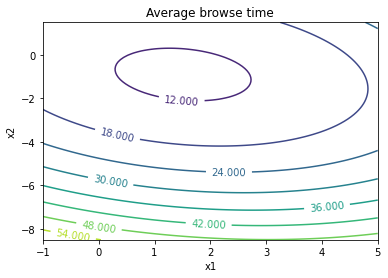

In [ ]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta12 = model.params[3]
beta11 = model.params[4]
beta22 = model.params[5]
x1, x2 = np.meshgrid(np.linspace(convertNtoC(U = 30, UH = 60, UL = 30), 
                                 convertNtoC(U = 120, UH = 60, UL = 30), 100), 
                     np.linspace(convertNtoC(U = 0, UH = 95, UL = 75), 
                                 convertNtoC(U = 100, UH = 95, UL = 75), 100))
eta = beta0 + beta1*x1 + beta2*x2 + beta12*x1*x2 + beta11*x1**2 + beta22*x2**2
pi = eta
h = plt.contour(x1, x2, pi)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Average browse time')
plt.show()

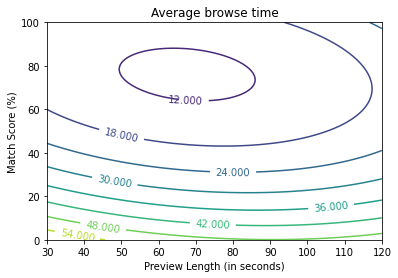

In [ ]:
h = plt.contour(convertCtoN(x1, UH=60, UL=30),
                convertCtoN(x2, UH=95, UL=75), pi)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('Preview Length (in seconds)')
plt.ylabel('Match Score (%)')
plt.title('Average browse time')
plt.show()

In [ ]:
b = np.matrix([beta1, beta2]).transpose()
B = np.matrix([[beta11, 0.5*beta12], [0.5*beta12, beta22]])
x_s = -0.5* np.matmul(np.linalg.inv(B), b)
print("When Preview Type = teaser/trailer, \nthe average browse time is maximized when x1=", x_s[0], "and x2=", x_s[1])

When Preview Type = teaser/trailer, 
the average browse time is maximized when x1= [[1.51099267]] and x2= [[-0.89884915]]


In [ ]:
xsN_1 = convertCtoN(x = x_s[0], UH = 60, UL = 30)
xsN_2 = convertCtoN(x = x_s[1], UH = 95, UL = 75)
print("Preview Length =", xsN_1, ", Match Score =", xsN_2)

Preview Length = [[67.66489011]] , Match Score = [[76.01150849]]


From the response surface we know that {Preview Length = 67.66489011, Match Score = 76.01150849} is the optimal condition for Preview Type = teaser/trailer, however, according to factors definition and limitation, we can only choose the closest feasible condition {Preview Length = 60, Match Score = 75} as the optimal condition, which conforms to the conclusion drawn from Student's t-test as well.

In [ ]:
eta_s = beta0 + 0.5*np.matmul(x_s.transpose(), b)
print(eta_s)

[[11.06107965]]


In [ ]:
yhat = model.predict(exog=dict(x1=convertNtoC(U = 67.66, UH = 60, UL = 30), 
                               x2=convertNtoC(U = 76.01, UH = 95, UL = 75)))
print(yhat.values)

[11.06107975]


In [ ]:
optimal = pd.DataFrame([[(70 - 45) / 15, (76 - 85) / 10]], columns=['x1', 'x2'])
prediction = model.get_prediction(optimal)\
                        .summary_frame(alpha=0.05)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pd.concat([optimal, prediction], axis=1)

,x1,x2,mean,mean_ci_lower,mean_ci_upper
0,1.666667,-0.9,11.076981,10.816003,11.33796
